In [1]:
import os
import glob
import hydromt
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
import pandas as pd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

In [2]:
# This script classifies the driver of peak water levels for each PGW run
# This script outputs a netcdf with the driver classification and a CSV with peak flood extent total areas
work_dir = r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_2'
out_dir = os.path.join(work_dir, 'driver_fldArea_stats')
if os.path.exists(out_dir) is False:
    os.makedirs(out_dir)
os.chdir(out_dir)

In [11]:
# Flooding was attributed to processes at the grid scale. The total number of cells is used to calculate the contribution
# of each flood process to the total area of the peak flood extent
fld_cells = pd.read_csv(os.path.join(work_dir, 'driver_analysis', 'pgw_drivers_classified_all_cellCount.csv'), index_col=0)

# Now we want to calculate what this area is in square km (rather than grid cell counts)
fld_area_file = os.path.join(work_dir, 'driver_analysis', 'pgw_drivers_classified_all_area.csv')
if os.path.exists(fld_area_file) is False:
    # Calculate the area of peak flooding per driver using the area of the grid cells
    fld_area = fld_cells.copy()
    res = 200  # grid cell resolution in meters
    fld_area = fld_area * (res * res) / (1000 ** 2)  # square km
    fld_area = fld_area.T

    # Combine into single compound flood driver, remove columns, calculate total cells flooded
    fld_area['compound'] = fld_area['compound_coastal'] + fld_area['compound_runoff']
    fld_area.to_csv(fld_area_file)
else:
    fld_area = pd.read_csv(fld_area_file, index_col=0)
print(fld_area.round(0))

                   no_flood  coastal  compound_coastal   runoff  \
flor_pres           99865.0   6583.0            4881.0  63213.0   
flor_fut_SF1_SLR1   98986.0   7257.0            5771.0  61104.0   
flor_fut_SF1_SLR2   98988.0   7124.0            5736.0  61410.0   
flor_fut_SF1_SLR3   98986.0   7292.0            5799.0  60944.0   
flor_fut_SF1_SLR4   98979.0   7796.0            5864.0  60166.0   
...                     ...      ...               ...      ...   
matt_fut_SF6_SLR1   98389.0   7577.0            4497.0  63177.0   
matt_fut_SF6_SLR2   98384.0   7924.0            4418.0  62874.0   
matt_fut_SF6_SLR3   98381.0   8120.0            4365.0  62618.0   
matt_fut_SF6_SLR4   98377.0   8378.0            4293.0  62321.0   
matt_fut_SF6_SLR5   98373.0   9070.0            3848.0  61960.0   

                   compound_runoff  compound  
flor_pres                   1618.0    6499.0  
flor_fut_SF1_SLR1           3043.0    8814.0  
flor_fut_SF1_SLR2           2902.0    8638.0  
flor_fu

In [12]:
# Data organization for boxplots
fld_area.drop(['no_flood', 'compound_coastal', 'compound_runoff'], axis=1, inplace=True)

# Add a column for total peak flood extent (sum of processes)
fld_area['Total'] = fld_area.sum(axis=1)

# Rename the columns
scenarios = ['Coastal', 'Runoff', 'Compound', 'Total']
fld_area.columns = scenarios

# Add some more information for grouping
fld_area['storm'] = [i.split("_")[0] for i in fld_area.index]
fld_area['climate'] = [i.split("_")[1] for i in fld_area.index]
fld_area['group'] = fld_area['storm'] + ' ' + fld_area['climate']

# Output
fld_area.to_csv(os.path.join(work_dir, 'driver_analysis', 'pgw_drivers_classified_all_area_2.csv'))

In [13]:
# Subset by present
pres_ensmean = fld_area[fld_area['climate'] == 'pres']
# Subset by future only
da_plot = fld_area.drop(fld_area[fld_area['climate'] == 'pres'].index)

In [14]:
# Plotting info
nrow = 4
ncol = 1

font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})
mpl.rcParams["figure.autolayout"] = True

n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)

props = dict(boxes="white", whiskers="black", caps="black")
boxprops = dict(facecolor='white', linestyle='--', linewidth=1, color='black')
flierprops = dict(marker='o', markerfacecolor='none', markersize=6, markeredgecolor='black')
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='lightgrey', markersize=6)

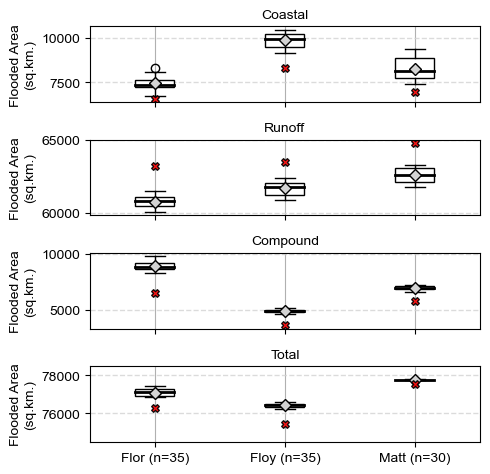

In [16]:
# PLOTTING Boxplot of flooded area
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, tight_layout=True, figsize=(5, 5))
axes = axes.flatten()
counter = 0
for ax in axes:
    bp = da_plot.boxplot(ax=ax,
                         by='group',
                         column=scenarios[counter],
                         vert=True,
                         color=props,
                         boxprops=boxprops,
                         flierprops=flierprops,
                         medianprops=medianprops,
                         meanprops=meanpointprops,
                         meanline=False,
                         showmeans=True,
                         patch_artist=True,
                         layout=(3, 1),
                         zorder=1
                         )
    ax.scatter(x=ax.get_xticks(), y=pres_ensmean[scenarios[counter]].values,
               s=30, color='red', marker='X', zorder=2, edgecolor='black', alpha=0.9)
    if counter == 3:
        ax.set_ylim(74500, 78500)

    if counter in last_row:
        xtick = ax.get_xticks()
        ax.set_xticklabels(['Flor (n=35)',
                            'Floy (n=35)',
                            'Matt (n=30)'])
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_title(scenarios[counter])
    ax.set_xlabel(None)
    ax.set_ylabel('Flooded Area\n(sq.km.)')
    kwargs = dict(linestyle='--', linewidth=1, color='lightgrey', alpha=0.8)
    ax.grid(visible=True, which='major', axis='y', zorder=0, **kwargs)
    kwargs = dict(linestyle='--', linewidth=0.5, color='lightgrey', alpha=0.8)
    ax.grid(visible=True, which='minor', axis='y', zorder=0, **kwargs)
    ax.set_axisbelow(True)
    counter += 1

plt.suptitle(None)
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
#plt.savefig('driver_fldArea_boxplot_ensmean.png', bbox_inches='tight', dpi=255)
#plt.close()

In [19]:
for storm in fld_area.storm.unique():
    for climate in fld_area.climate.unique():
        sub = da_plot[da_plot['storm'] == storm][da_plot['climate'] == climate]
        if climate == 'fut':
            stats = sub.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
            stats.to_csv(f'{storm}_{climate}_driver_fldArea_stats.csv')
print(stats.round(0))

       Coastal   Runoff  Compound    Total
count     30.0     30.0      30.0     30.0
mean    8263.0  62587.0    6926.0  77776.0
std      637.0    491.0     179.0     11.0
min     7395.0  61793.0    6561.0  77753.0
5%      7462.0  61831.0    6587.0  77756.0
25%     7767.0  62106.0    6806.0  77770.0
50%     8139.0  62611.0    6970.0  77780.0
75%     8873.0  63080.0    7073.0  77785.0
95%     9262.0  63204.0    7133.0  77789.0
max     9344.0  63273.0    7163.0  77792.0
